This code reproduces the comparison between the electrophysiological data and the calcium data.

### Instructions:
1. (Optional) Before proceeding, place the rotated `.PNG` files (e.g., the 2D projection of 3D mapping) into the `data` subfolder and name them as:
   - `top.PNG`
   - `bottom.PNG`
   - `Calcium.PNG`

2. (Optional) Crop the `.PNG` files so that they form a square, ensuring the edges touch the boundary of the mapping. This means creating the smallest possible square that captures the entire image.

3. The current folder is already filled with the necessary `.PNG` files. You can directly use the provided example without the previous step.


Step 1: Scale to same Dimension
Different images have different dimensions. Therefore, scale all images to match the smallest image among them.  

This scaling is based on the assumption that all images have the same radius.


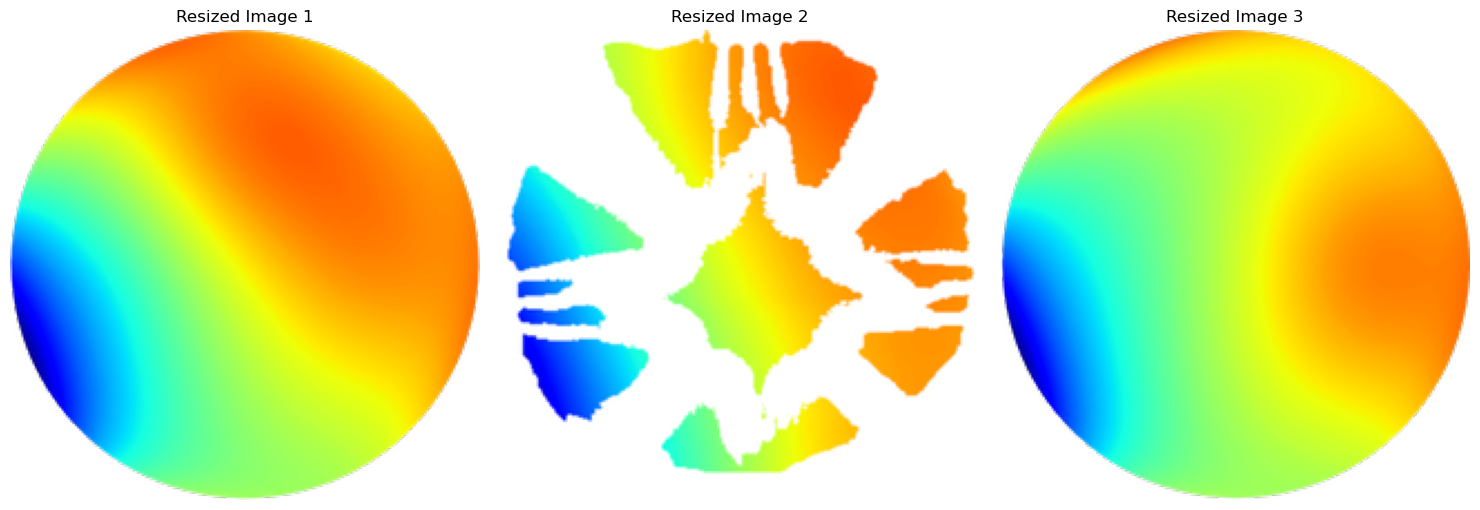

In [8]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the images
image1_path = 'data/bottom.png'
image2_path = 'data/Calcium.png'
image3_path = 'data/top.png'

image1 = Image.open(image1_path)
image2 = Image.open(image2_path)
image3 = Image.open(image3_path)

# Find the smallest size among all three images
smallest_size = min(
    image1.size[0], image1.size[1],
    image2.size[0], image2.size[1],
    image3.size[0], image3.size[1]
)
smallest_size = 211
# Resize all three images to the smallest size using the updated resampling method
image1_resized = image1.resize((smallest_size, smallest_size), Image.Resampling.LANCZOS)
image2_resized = image2.resize((smallest_size, smallest_size), Image.Resampling.LANCZOS)
image3_resized = image3.resize((smallest_size, smallest_size), Image.Resampling.LANCZOS)

# Convert images to numpy matrices
image1_matrix = np.array(image1_resized)
image2_matrix = np.array(image2_resized)
image3_matrix = np.array(image3_resized)

# Save the processed matrices
np.save('data/image1_matrix.npy', image1_matrix)
np.save('data/image2_matrix.npy', image2_matrix)
np.save('data/image3_matrix.npy', image3_matrix)

# Plot the resized images
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)
plt.title("Resized Image 1")
plt.imshow(image1_resized)
plt.axis('off')

# Plot the second image
plt.subplot(1, 3, 2)
plt.title("Resized Image 2")
plt.imshow(image2_resized)
plt.axis('off')

# Plot the third image
plt.subplot(1, 3, 3)
plt.title("Resized Image 3")
plt.imshow(image3_resized)
plt.axis('off')

plt.tight_layout()
plt.show()

Step 2: Extract colormap

Run ExtractColorMap.py (Optional)


This code extracts the color from the JET mapping to numeric data, which can be used to map the projection value back to the latency value.  

This step is optional, as the mapped values already include the color information in the file **`color_bar_valuesP.npy`**.


Step 3: Map back

This code maps the projection of the 2D data back to the latency value by calculating the distance between the color in the figure and the corresponding value in the ground truth (GT) mapping in HSV space.  

### About HSV vs. RGB:
- **HSV (Hue, Saturation, Value)** is a color space that represents colors in terms of:
  - **Hue (H):** The type of color (e.g., red, blue, green) measured in degrees (0-360°).
  - **Saturation (S):** The intensity or purity of the color (0-100%).
  - **Value (V):** The brightness of the color (0-100%).

- **RGB (Red, Green, Blue)** represents colors as a combination of red, green, and blue light intensities (0-255 per channel).

By using HSV space, the mapping process becomes feasible as it the distance represents the distance in JET map


Loading data...
Creating color mapping...
Processing image 1...
Processing row 0/211
Processing row 50/211
Processing row 100/211
Processing row 150/211
Processing row 200/211


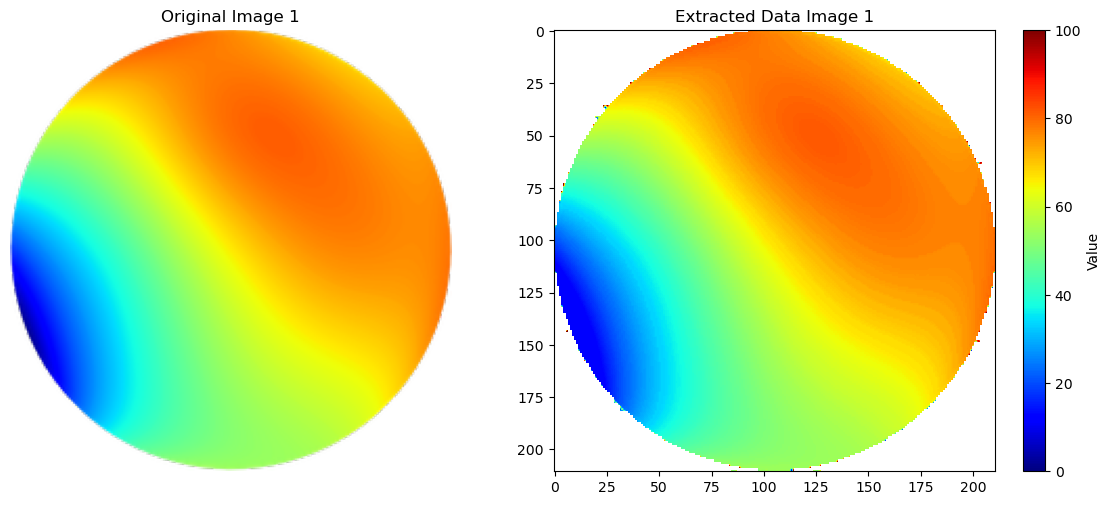

Processing image 2...
Processing row 0/211
Processing row 50/211
Processing row 100/211
Processing row 150/211
Processing row 200/211


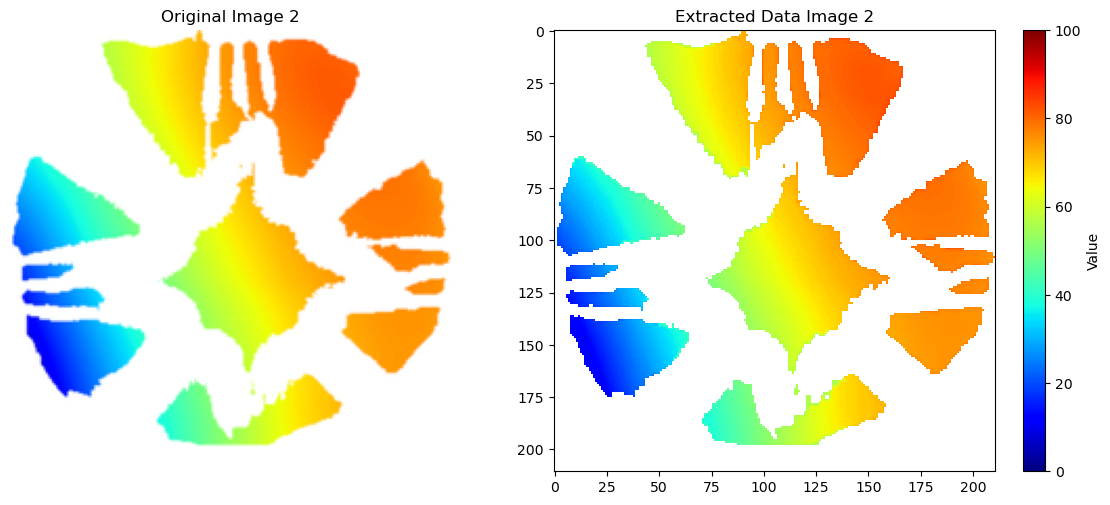

Processing image 3...
Processing row 0/211
Processing row 50/211
Processing row 100/211
Processing row 150/211
Processing row 200/211


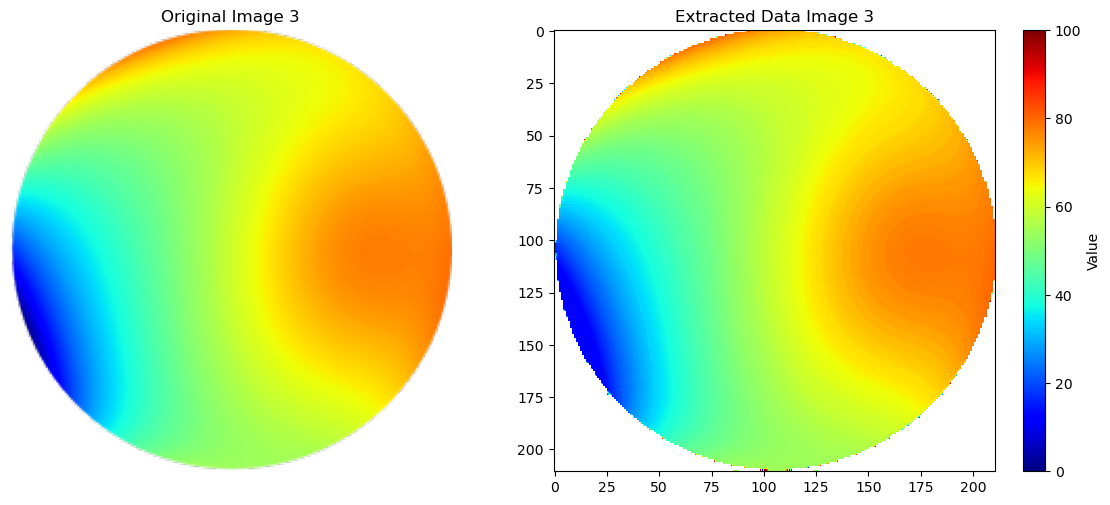

Saving results...


In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import colorsys

def rgb_to_hsv(rgb):
    r, g, b = rgb[0]/255.0, rgb[1]/255.0, rgb[2]/255.0
    h, s, v = colorsys.rgb_to_hsv(r, g, b)
    return h, s, v

def hue_distance(h1, h2):
    diff = abs(h1 - h2)
    return min(diff, 1.0 - diff)

def load_data():
    image1_matrix = np.load('data/image1_matrix.npy')
    image2_matrix = np.load('data/image2_matrix.npy')
    image3_matrix = np.load('data/image3_matrix.npy')  # Added image3
    colorbar_values = np.load('colorbar_values.npy')
    return image1_matrix, image2_matrix, image3_matrix, colorbar_values  # Return image3

def create_value_mapping(colorbar_values):
    num_values = len(colorbar_values)
    numerical_values = np.linspace(0, 100, num_values)
    
    hsv_values = []
    for rgb in colorbar_values:
        h, s, v = rgb_to_hsv(rgb)
        hsv_values.append((h, s, v))
    
    return numerical_values, np.array(hsv_values)

def is_white_pixel(pixel, threshold=250):
    if len(pixel) == 4:
        r, g, b, a = pixel
        if a == 0:
            return 1
        else:
            return all(value >= threshold for value in [r, g, b])
    else:
        return all(value >= threshold for value in pixel)

def find_nearest_value(pixel_rgb, colorbar_hsv, mapped_values):
    if is_white_pixel(pixel_rgb):
        return np.nan
    
    rgb_values = pixel_rgb[:3] if len(pixel_rgb) == 4 else pixel_rgb
    pixel_h, pixel_s, pixel_v = rgb_to_hsv(rgb_values)
    
    distances = []
    for ref_hsv in colorbar_hsv:
        ref_h = ref_hsv[0]
        hue_dist = hue_distance(pixel_h, ref_h)
        sat_dist = abs(pixel_s - ref_hsv[1])
        val_dist = abs(pixel_v - ref_hsv[2])
        total_dist = hue_dist * 0.6 + sat_dist * 0.2 + val_dist * 0.2
        distances.append(total_dist)
    
    nearest_idx = np.argmin(distances)
    return 100 - mapped_values[nearest_idx]

def process_image(image_matrix, colorbar_hsv, mapped_values):
    height, width = image_matrix.shape[:2]
    result_matrix = np.zeros((height, width))
    
    for i in range(height):
        for j in range(width):
            pixel_rgb = image_matrix[i, j]
            result_matrix[i, j] = find_nearest_value(pixel_rgb, colorbar_hsv, mapped_values)
        if i % 50 == 0:
            print(f"Processing row {i}/{height}")
    
    return result_matrix

def plot_comparison(image_matrix, extracted_data, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.imshow(image_matrix)
    ax1.set_title(f'Original {title}')
    ax1.axis('off')
    
    cmap = plt.cm.jet.copy()
    cmap.set_bad('white')
    
    im = ax2.imshow(extracted_data, cmap=cmap, vmin=0, vmax=100)
    ax2.set_title(f'Extracted Data {title}')
    plt.colorbar(im, ax=ax2, label='Value')
    
    plt.tight_layout()
    plt.show()

def main():
    print("Loading data...")
    image1_matrix, image2_matrix, image3_matrix, colorbar_values = load_data()
    
    print("Creating color mapping...")
    mapped_values, colorbar_hsv = create_value_mapping(colorbar_values)
    
    print("Processing image 1...")
    data1 = process_image(image1_matrix, colorbar_hsv, mapped_values)
    plot_comparison(image1_matrix, data1, "Image 1")
    
    print("Processing image 2...")
    data2 = process_image(image2_matrix, colorbar_hsv, mapped_values)
    plot_comparison(image2_matrix, data2, "Image 2")
    
    print("Processing image 3...")  # Added image3 processing
    data3 = process_image(image3_matrix, colorbar_hsv, mapped_values)
    plot_comparison(image3_matrix, data3, "Image 3")
    
    print("Saving results...")
    np.save('data/extracted_data1.npy', data1)
    np.save('data/extracted_data2.npy', data2)
    np.save('data/extracted_data3.npy', data3)  # Save data3
    
    return data1, data2, data3  # Return data3

if __name__ == "__main__":
    extracted_data1, extracted_data2, extracted_data3 = main()

Step 4 Calculate LAT

This piece of code identifies common points between different figures, detects their latency, and computes the correlation statistic.  

### Process:
1. **Find common points** – Only points that exist in both figures are selected.
2. **Detect latency** – Extract the latency values corresponding to these common points.
3. **Compute correlation** – Analyze the relationship between the latency values using statistical correlation measures.


In [10]:
SAMPLING_RATE = 8 # This is among how many pixels we select one pixel

Loading and scaling processed data...

Analyzing Image 1 vs Image 2...


D:\temp\ipykernel_43332\93697449.py:152: RuntimeWarning: Mean of empty slice
  data_mean13 = np.nanmean(np.stack([data1, data3]), axis=0)


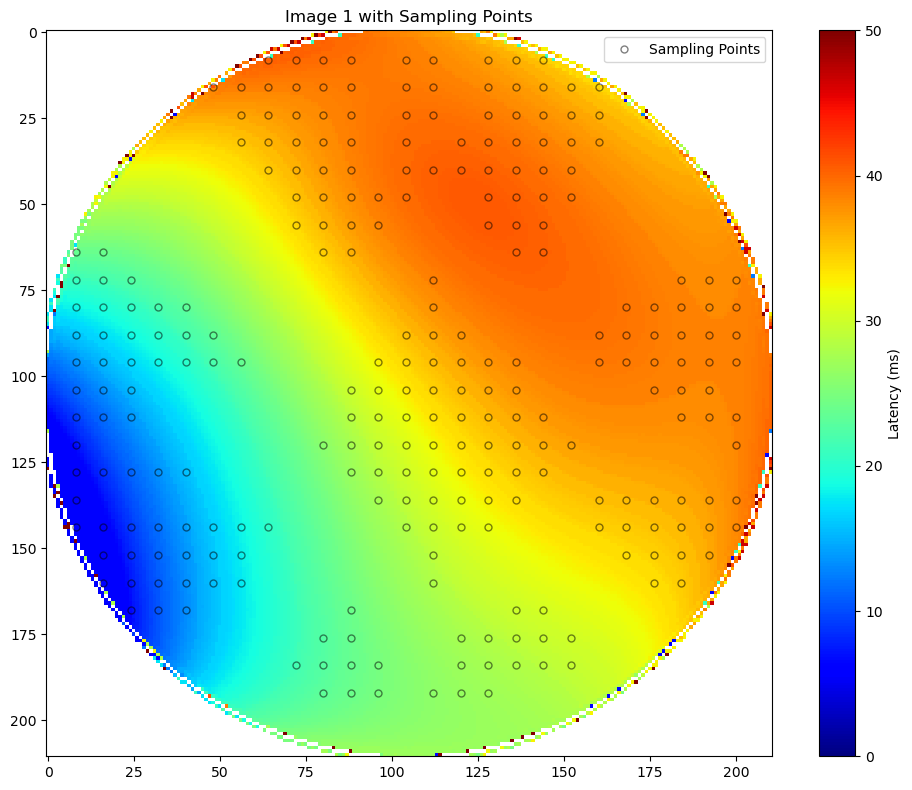

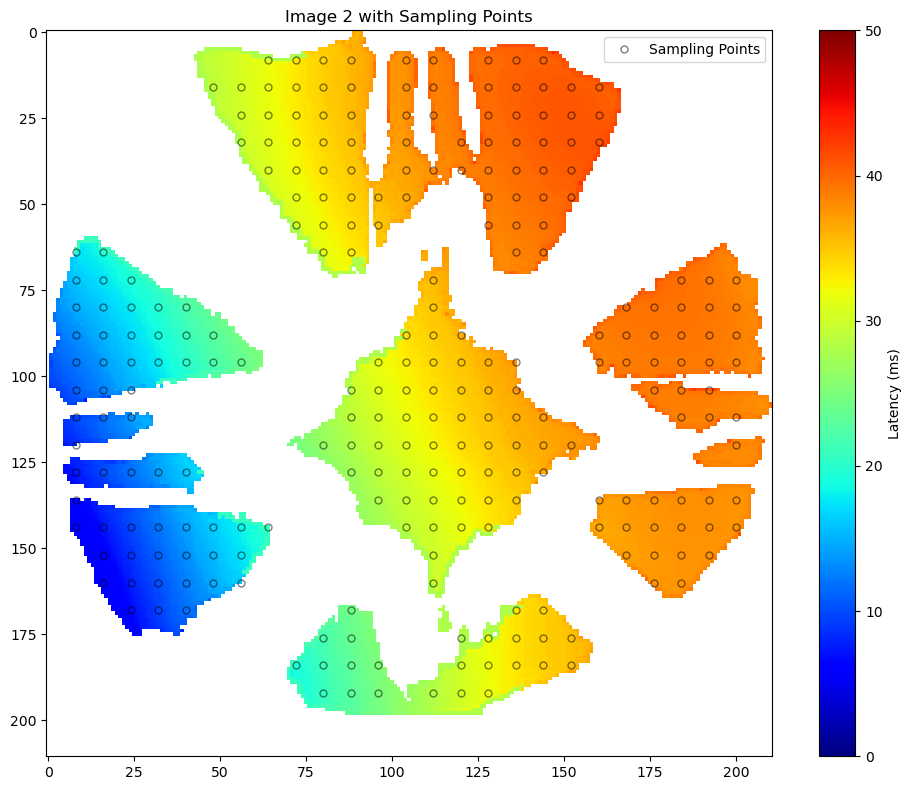


Detailed Statistics for Image 1 vs Image 2:
--------------------------------------------------
Correlation Analysis:
  Pearson Correlation (r) = 0.964
  P-value = 2.45e-152

Error Metrics:
  Root Mean Square Error = 2.63 ms
  Mean Absolute Error = 1.83 ms

Accuracy Thresholds:
  Within ±1ms: 43.1%
  Within ±2ms: 64.1%
  Within ±5ms: 93.1%


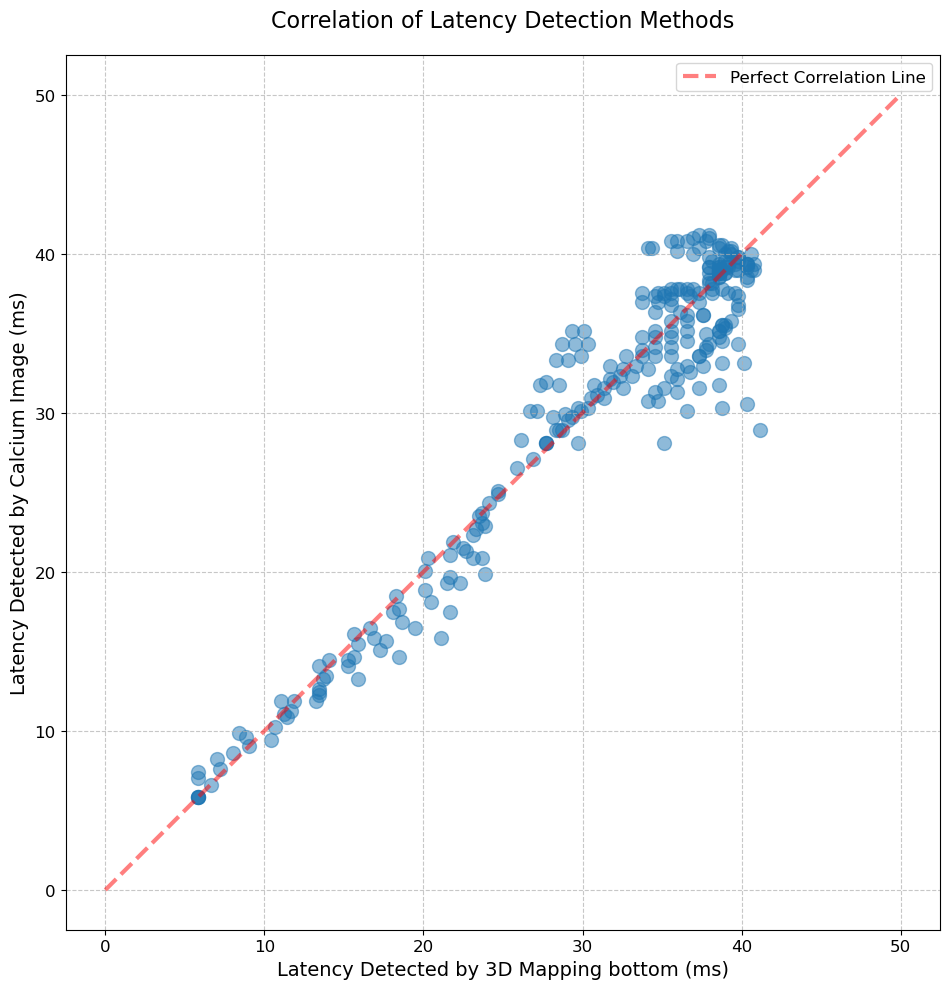

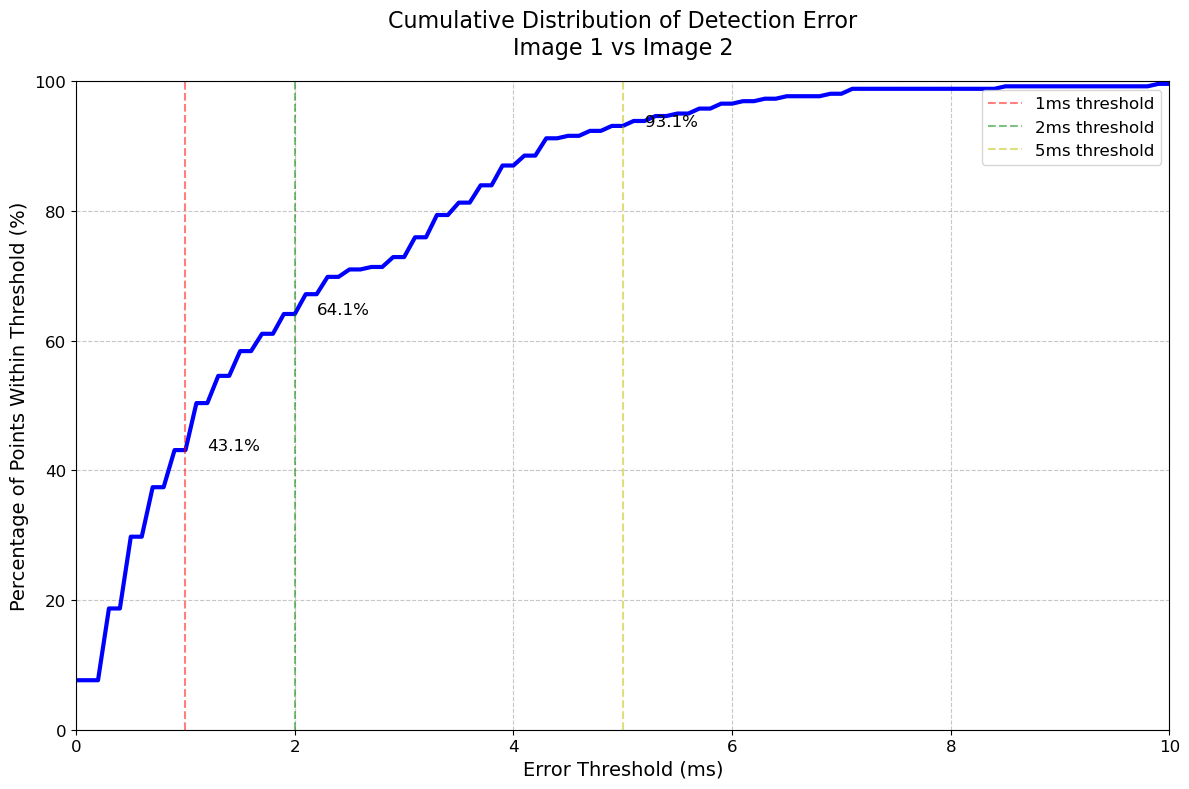


Analyzing Image 2 vs Image 3...


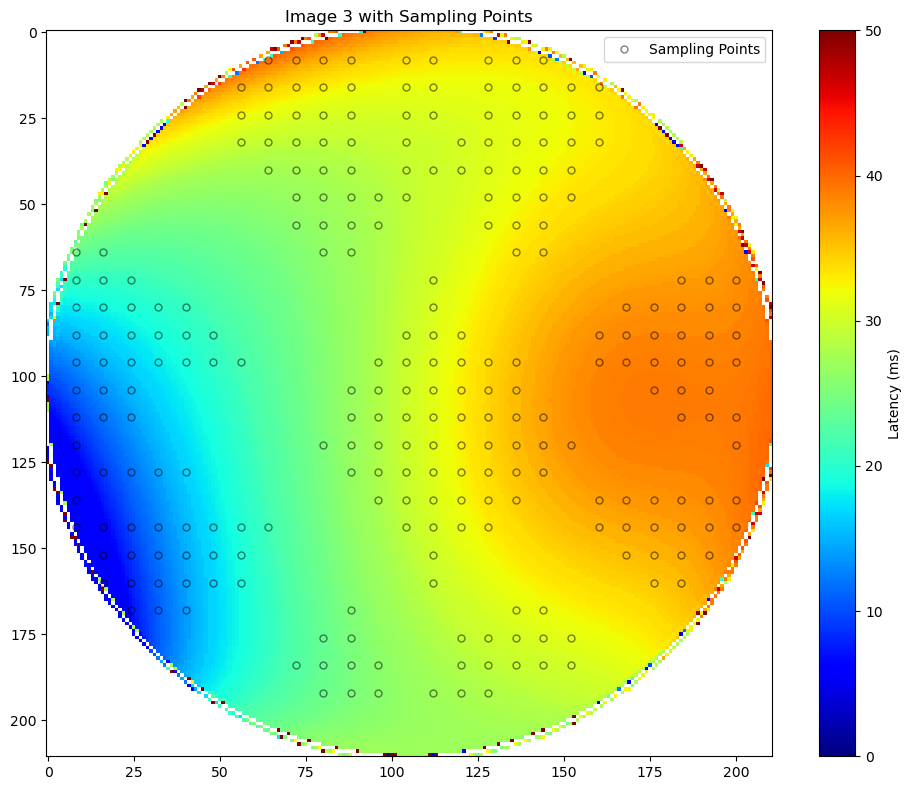

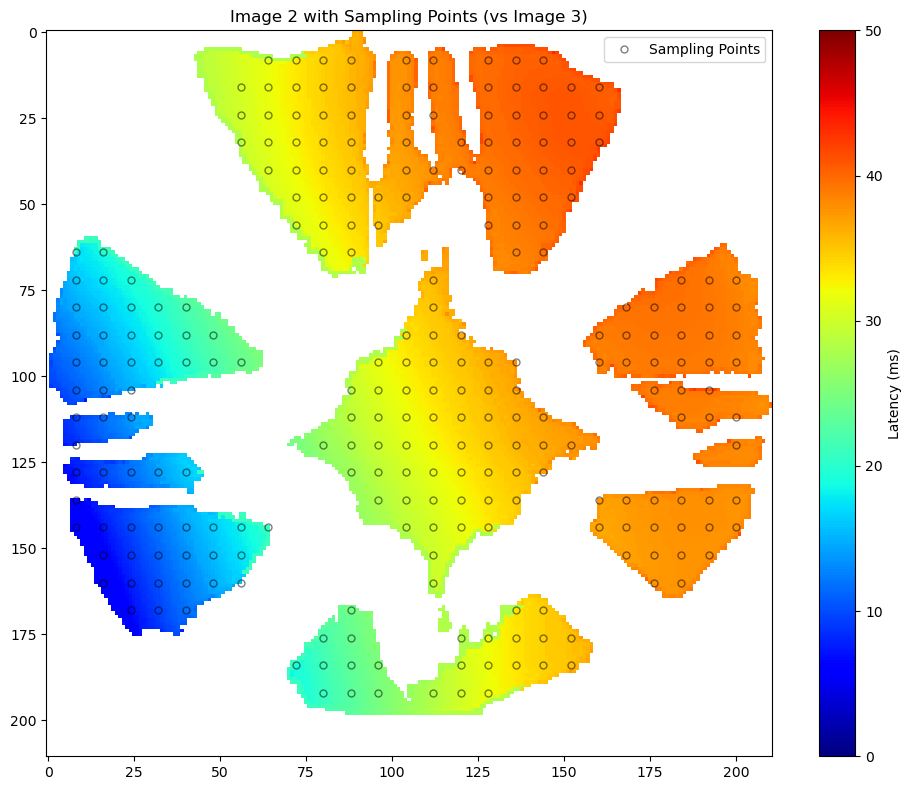


Detailed Statistics for Image 2 vs Image 3:
--------------------------------------------------
Correlation Analysis:
  Pearson Correlation (r) = 0.945
  P-value = 2.41e-127

Error Metrics:
  Root Mean Square Error = 3.85 ms
  Mean Absolute Error = 2.74 ms

Accuracy Thresholds:
  Within ±1ms: 31.4%
  Within ±2ms: 53.6%
  Within ±5ms: 78.2%


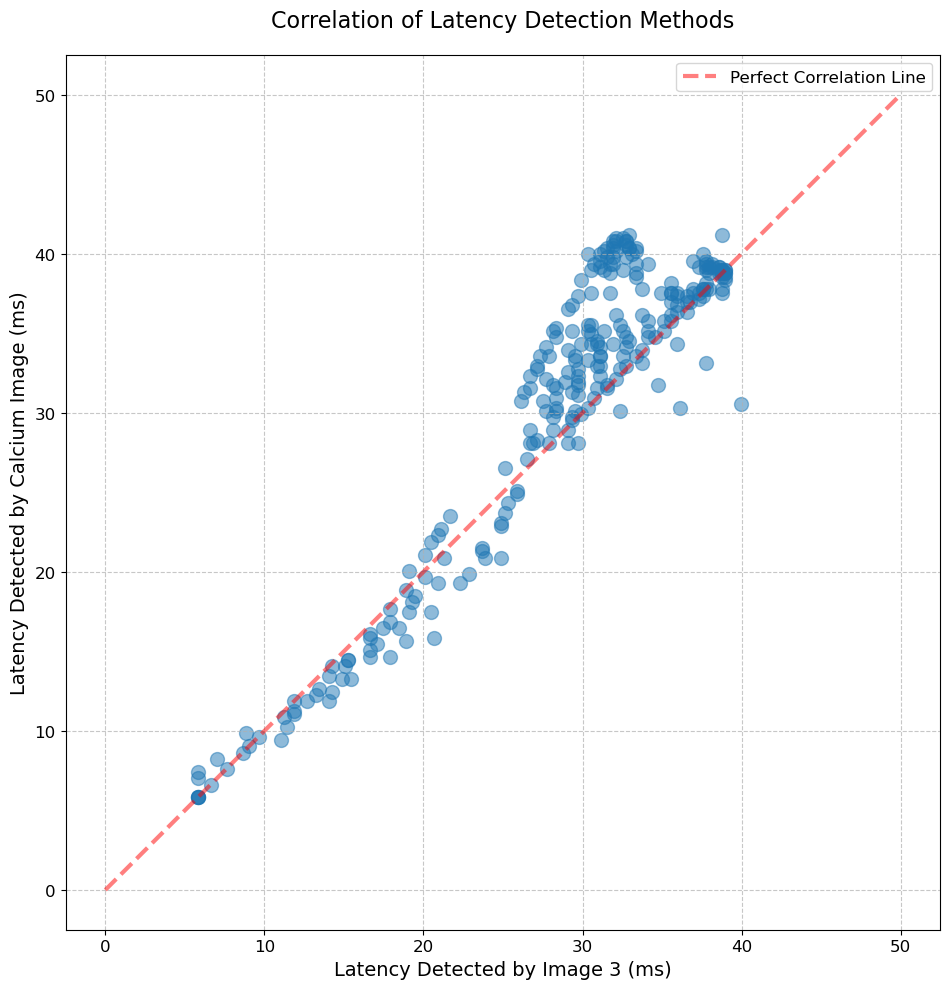

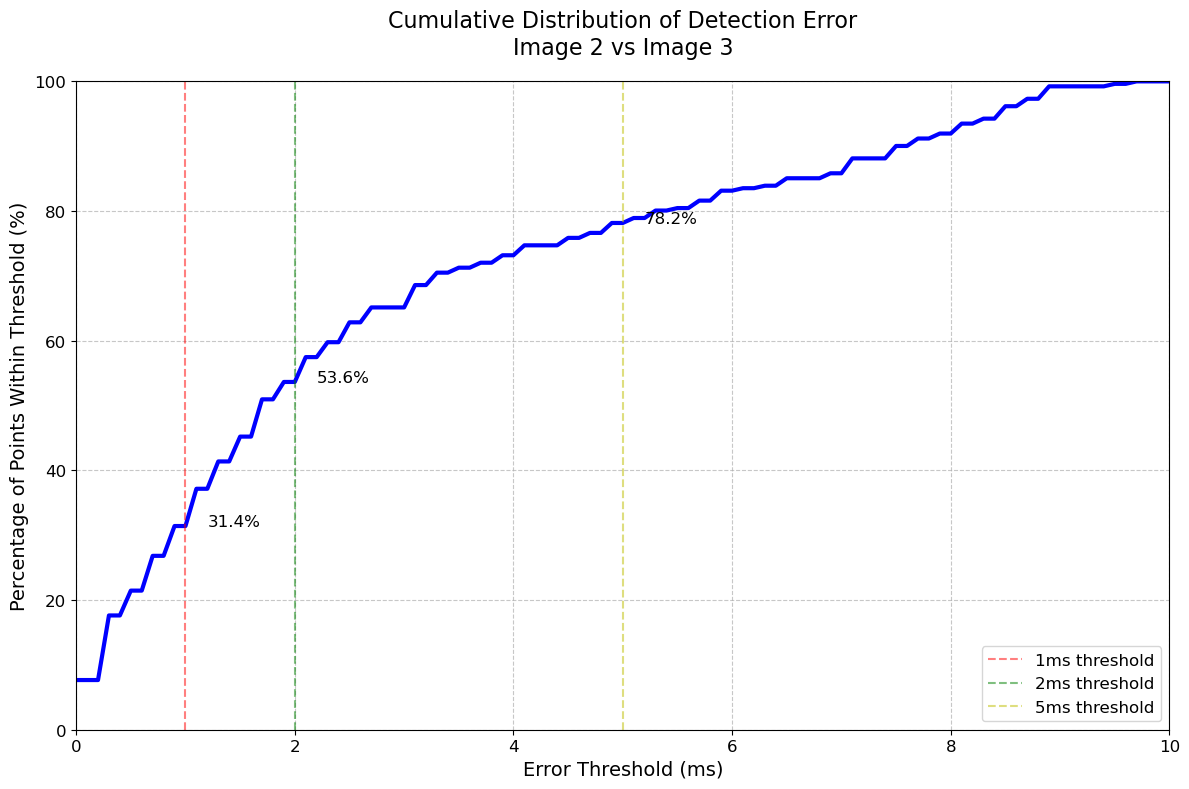


Analyzing Mean(Image1,Image3) vs Image 2...


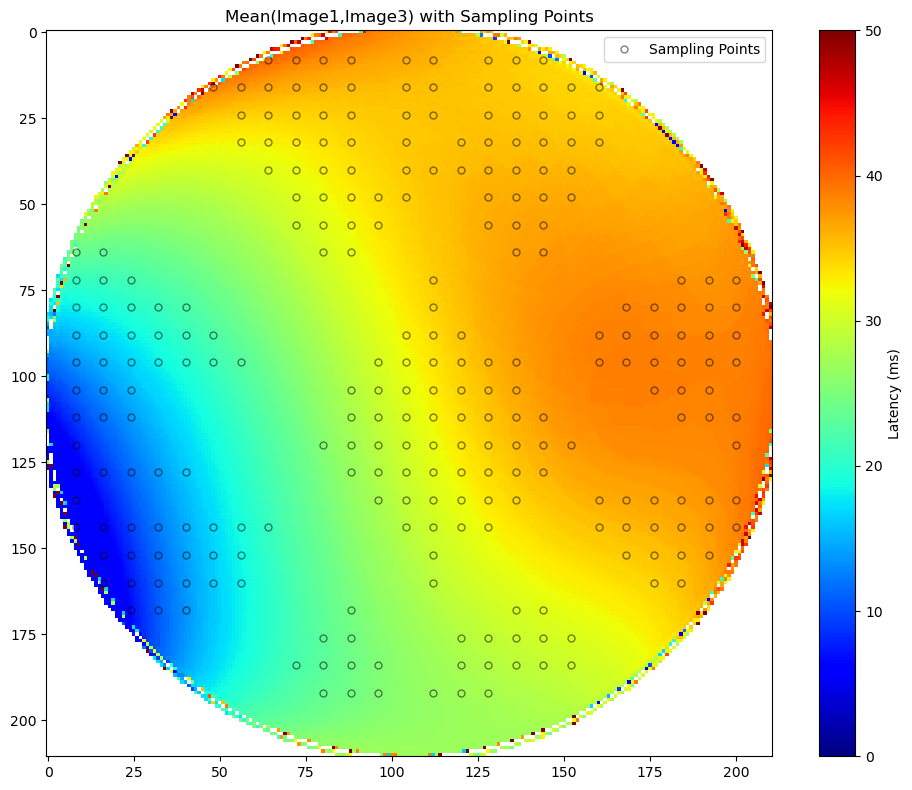

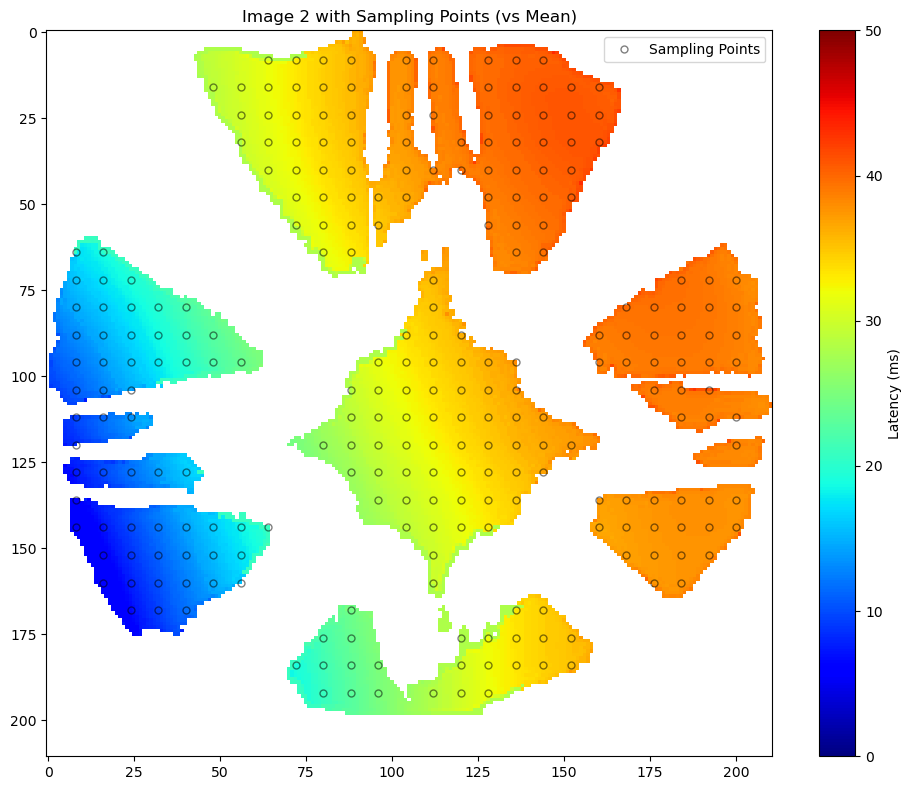


Detailed Statistics for Mean(Image1,Image3) vs Image 2:
--------------------------------------------------
Correlation Analysis:
  Pearson Correlation (r) = 0.970
  P-value = 2.85e-161

Error Metrics:
  Root Mean Square Error = 2.59 ms
  Mean Absolute Error = 1.78 ms

Accuracy Thresholds:
  Within ±1ms: 45.0%
  Within ±2ms: 68.7%
  Within ±5ms: 92.4%


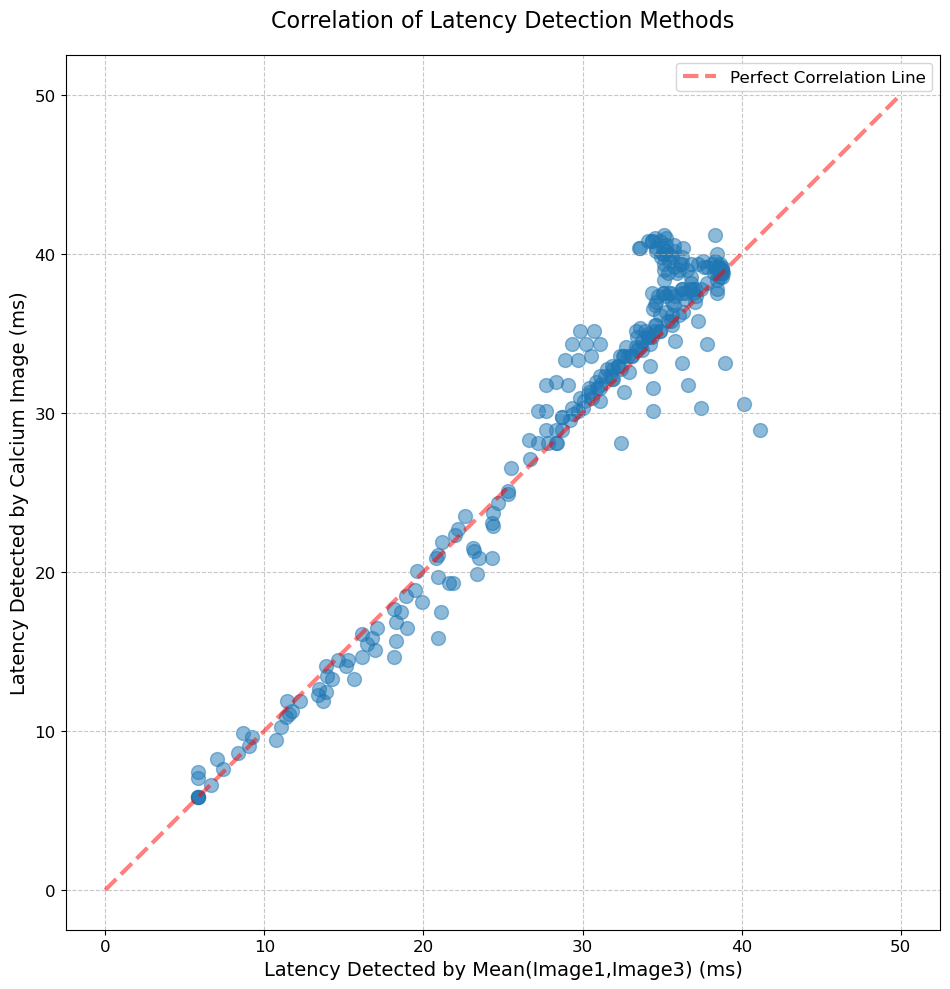

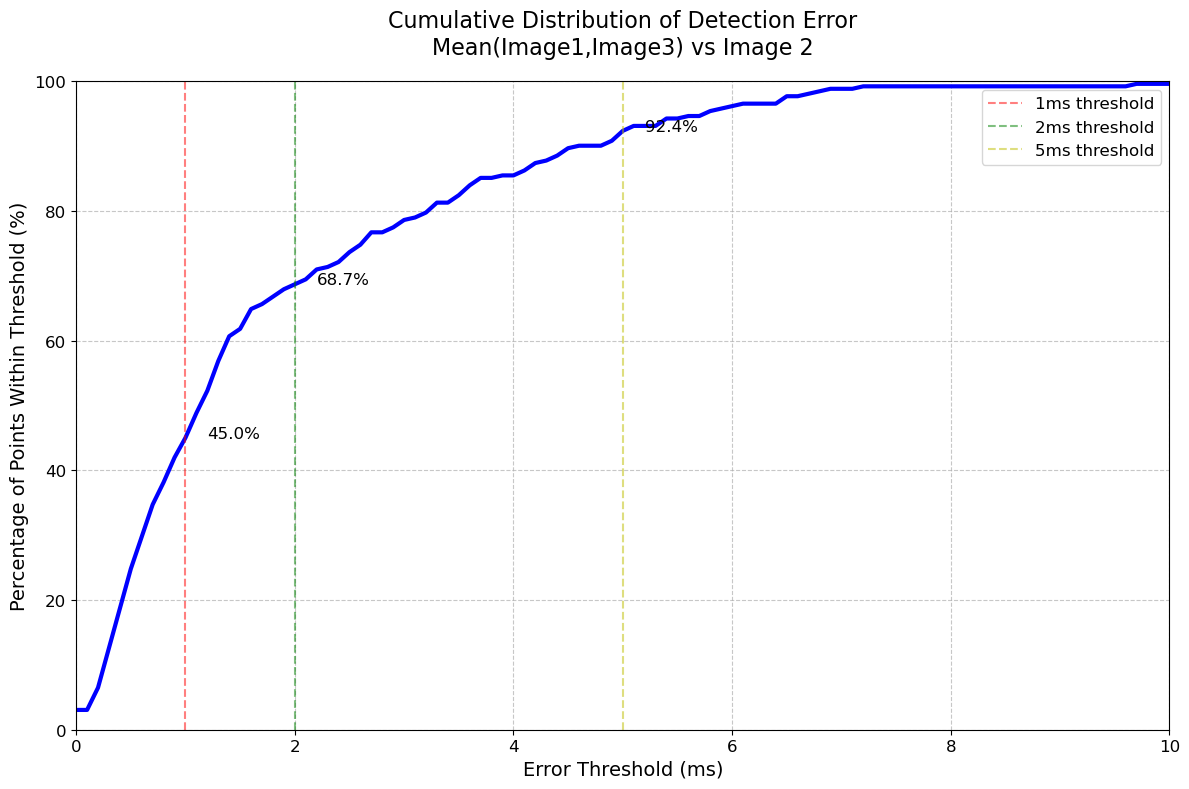

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

def load_processed_data():
    data1 = np.load('data/extracted_data1.npy')
    data2 = np.load('data/extracted_data2.npy')
    data3 = np.load('data/extracted_data3.npy')
    return data1/2, data2/2, data3/2

def sample_and_pair_data(data1, data2, sampling_rate=SAMPLING_RATE):
    height, width = data1.shape
    values1 = []
    values2 = []
    sampling_points = []  # Store the coordinates of sampling points
    
    for i in range(0, height, sampling_rate):
        for j in range(0, width, sampling_rate):
            val1 = data1[i, j]
            val2 = data2[i, j]
            
            if not (np.isnan(val1) or np.isnan(val2)):
                values1.append(val1)
                values2.append(val2)
                sampling_points.append((i, j))  # Store the coordinates
    
    return np.array(values1), np.array(values2), sampling_points

def plot_isochronal_map_with_points(data, sampling_points, title):
    plt.figure(figsize=(10, 8))
    
    # Create custom colormap that makes NaN values white
    cmap = plt.cm.jet.copy()
    cmap.set_bad('white')
    
    # Plot the isochronal map
    plt.imshow(data, cmap=cmap, vmin=0, vmax=50)
    plt.colorbar(label='Latency (ms)')
    
    # Plot sampling points as hollow circles
    if sampling_points:
        points = np.array(sampling_points)
        plt.plot(points[:, 1], points[:, 0], 'o', 
                markerfacecolor='none', markeredgecolor='black', 
                markeredgewidth=1, markersize=5, alpha=0.5,
                label='Sampling Points')
    
    plt.title(title)
    plt.axis('on')  # Show axes to better visualize point locations
    plt.legend()
    plt.tight_layout()
    plt.show()

def calculate_statistics(values1, values2):
    correlation, p_value = stats.pearsonr(values1, values2)
    mse = mean_squared_error(values2, values1)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(values2, values1)
    
    diff = np.abs(values1 - values2)
    acc_1ms = np.mean(diff <= 1) * 100
    acc_2ms = np.mean(diff <= 2) * 100
    acc_5ms = np.mean(diff <= 5) * 100
    
    return {
        'correlation': correlation,
        'p_value': p_value,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'acc_1ms': acc_1ms,
        'acc_2ms': acc_2ms,
        'acc_5ms': acc_5ms
    }

def print_statistics(stats, comparison_name=""):
    print(f"\nDetailed Statistics for {comparison_name}:")
    print("-" * 50)
    print(f"Correlation Analysis:")
    print(f"  Pearson Correlation (r) = {stats['correlation']:.3f}")
    print(f"  P-value = {stats['p_value']:.2e}")
    print("\nError Metrics:")
    print(f"  Root Mean Square Error = {stats['rmse']:.2f} ms")
    print(f"  Mean Absolute Error = {stats['mae']:.2f} ms")
    print("\nAccuracy Thresholds:")
    print(f"  Within ±1ms: {stats['acc_1ms']:.1f}%")
    print(f"  Within ±2ms: {stats['acc_2ms']:.1f}%")
    print(f"  Within ±5ms: {stats['acc_5ms']:.1f}%")

def create_correlation_plot(values1, values2, title1, title2):
    plt.figure(figsize=(12, 10))
    
    plt.scatter(values1, values2, alpha=0.5, s=100)
    
    plt.xlabel(f'Latency Detected by {title1} (ms)', fontsize=14)
    plt.ylabel(f'Latency Detected by {title2} (ms)', fontsize=14)
    plt.title('Correlation of Latency Detection Methods', fontsize=16, pad=20)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    
    plt.plot([0, 50], [0, 50], 'r--', alpha=0.5, linewidth=3, label='Perfect Correlation Line')
    plt.legend(fontsize=12)
    plt.axis('square')
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    plt.show()

def create_cumulative_accuracy_plot(values1, values2, comparison_name=""):
    differences = np.abs(values1 - values2)
    thresholds = np.arange(0, 10.1, 0.1)
    percentages = []
    
    for thresh in thresholds:
        percent = np.mean(differences <= thresh) * 100
        percentages.append(percent)
    
    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, percentages, 'b-', linewidth=3)
    
    plt.xlabel('Error Threshold (ms)', fontsize=14)
    plt.ylabel('Percentage of Points Within Threshold (%)', fontsize=14)
    plt.title(f'Cumulative Distribution of Detection Error\n{comparison_name}', fontsize=16, pad=20)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 10)
    plt.ylim(0, 100)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    for thresh, style in [(1, 'r--'), (2, 'g--'), (5, 'y--')]:
        plt.axvline(x=thresh, linestyle='--', color=style[0], alpha=0.5,
                   label=f'{thresh}ms threshold')
        y_val = np.interp(thresh, thresholds, percentages)
        plt.text(thresh+0.2, y_val, f'{y_val:.1f}%', fontsize=12)
    
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

def main():
    print("Loading and scaling processed data...")
    data1, data2, data3 = load_processed_data()
    
    # Calculate mean of image1 and image3
    data_mean13 = np.nanmean(np.stack([data1, data3]), axis=0)
    
    # Original comparison (Image 1 vs 2)
    print("\nAnalyzing Image 1 vs Image 2...")

    values1_2, values2, sampling_points_1_2 = sample_and_pair_data(data1, data2, sampling_rate=SAMPLING_RATE)
    stats1_2 = calculate_statistics(values1_2, values2)
    
    # Plot isochronal maps with sampling points
    plot_isochronal_map_with_points(data1, sampling_points_1_2, "Image 1 with Sampling Points")
    plot_isochronal_map_with_points(data2, sampling_points_1_2, "Image 2 with Sampling Points")
    
    print_statistics(stats1_2, "Image 1 vs Image 2")
    create_correlation_plot(values1_2, values2, "3D Mapping bottom", "Calcium Image")
    create_cumulative_accuracy_plot(values1_2, values2, "Image 1 vs Image 2")
    
    # Image 2 vs Image 3
    print("\nAnalyzing Image 2 vs Image 3...")
    values3_2, values2_3, sampling_points_2_3 = sample_and_pair_data(data3, data2, sampling_rate=SAMPLING_RATE)
    stats2_3 = calculate_statistics(values3_2, values2_3)
    
    # Plot isochronal maps with sampling points
    plot_isochronal_map_with_points(data3, sampling_points_2_3, "Image 3 with Sampling Points")
    plot_isochronal_map_with_points(data2, sampling_points_2_3, "Image 2 with Sampling Points (vs Image 3)")
    
    print_statistics(stats2_3, "Image 2 vs Image 3")
    create_correlation_plot(values3_2, values2_3, "Image 3", "Calcium Image")
    create_cumulative_accuracy_plot(values3_2, values2_3, "Image 2 vs Image 3")
    
    # Mean(Image1,Image3) vs Image 2
    print("\nAnalyzing Mean(Image1,Image3) vs Image 2...")
    values_mean13, values2_mean, sampling_points_mean = sample_and_pair_data(data_mean13, data2, sampling_rate=SAMPLING_RATE)
    stats_mean = calculate_statistics(values_mean13, values2_mean)
    
    # Plot isochronal maps with sampling points
    plot_isochronal_map_with_points(data_mean13, sampling_points_mean, "Mean(Image1,Image3) with Sampling Points")
    plot_isochronal_map_with_points(data2, sampling_points_mean, "Image 2 with Sampling Points (vs Mean)")
    
    print_statistics(stats_mean, "Mean(Image1,Image3) vs Image 2")
    create_correlation_plot(values_mean13, values2_mean, "Mean(Image1,Image3)", "Calcium Image")
    create_cumulative_accuracy_plot(values_mean13, values2_mean, "Mean(Image1,Image3) vs Image 2")
    
    return {
        'image1_vs_2': (values1_2, values2, stats1_2, sampling_points_1_2),
        'image2_vs_3': (values3_2, values2_3, stats2_3, sampling_points_2_3),
        'mean_vs_2': (values_mean13, values2_mean, stats_mean, sampling_points_mean)
    }

if __name__ == "__main__":
    results = main()

Step 5 Calculate CV

CV are calculated at the points where both figures exists. A threshold is set at 10 centimeter per seconds to avoid numerically large conduction velocities on certain directions. 

# **Mathematical Formulation of Conduction Velocity Calculation**

## **Step 1: Compute Distance Between Points**
For adjacent points \( p = (i, j) \) and \( p' = (i + \Delta i, j + \Delta j) \), the spatial distance is:

$$
d = \frac{s \cdot d_{\text{pixel}}}{\text{scale}}
$$

where \( d_{\text{pixel}} \) is first scaled to ensure appropriate units.

## **Step 2: Compute Velocity**
The conduction velocity is computed as:

$$
v = \frac{d}{\Delta t / \text{scale}}
$$

where \( \Delta t \) is:

$$
\Delta t = d(i+\Delta i, j+\Delta j) - d(i, j)
$$

Thus, the conduction velocity simplifies to:

$$
v = \frac{s \cdot d_{\text{pixel}}}{\Delta t}
$$

## **Step 3: Apply Velocity Threshold**
A threshold \( v_{\max} \) is applied:

$$
|v| \leq v_{\max}
$$

## **Step 4: Compute Velocity Components**
For each direction (up, down, left, right), the velocity is decomposed:

$$
dx = \frac{\Delta j \cdot d_{\text{pixel}}}{\text{scale}}, \quad dy = \frac{\Delta i \cdot d_{\text{pixel}}}{\text{scale}}
$$

The magnitude of the distance vector:

$$
\text{dist} = \sqrt{dx^2 + dy^2}
$$

Velocity components:

$$
v_x = v \cdot \frac{dx}{\text{dist}}, \quad v_y = v \cdot \frac{dy}{\text{dist}}
$$

## **Step 5: Compute Mean Velocity**
The mean velocity is:

$$
\bar{v}_x = \frac{1}{N} \sum_{k=1}^{N} v_{x,k}, \quad
\bar{v}_y = \frac{1}{N} \sum_{k=1}^{N} v_{y,k}
$$

Final conduction velocity:

$$
V = \sqrt{\bar{v}_x^2 + \bar{v}_y^2}
$$

with the condition:

$$
V \leq v_{\max}
$$


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def calculate_velocities(data, sampling_points, sampling_rate=SAMPLING_RATE, pixel_size=2.89, max_velocity=10):
    pixel_size = pixel_size/10 #So that the unit is cm/s
    velocities = []
    positions = []
    
    points = np.array(sampling_points)
    
    for idx, (i, j) in enumerate(points):
        if np.isnan(data[i, j]):
            continue
            
        local_velocities = []
        
        adjacent_offsets = [
            (-sampling_rate, 0),  # up
            (sampling_rate, 0),   # down
            (0, -sampling_rate),  # left
            (0, sampling_rate)    # right
        ]
        
        for di, dj in adjacent_offsets:
            ni, nj = i + di, j + dj
            
            if (0 <= ni < data.shape[0] and 
                0 <= nj < data.shape[1] and 
                not np.isnan(data[ni, nj])):
                
                adjacent_idx = np.where((points == [ni, nj]).all(axis=1))[0]
                
                if len(adjacent_idx) > 0:
                    dt = data[ni, nj] - data[i, j]
                    
                    distance = sampling_rate * pixel_size / 1000
                    
                    if dt != 0:
                        velocity = distance / (dt / 1000)
                        
                        if abs(velocity) <= max_velocity:  # Filter out high velocities
                            dx = dj * pixel_size / 1000
                            dy = di * pixel_size / 1000
                            
                            dist = np.sqrt(dx**2 + dy**2)
                            vx = velocity * (dx / dist)
                            vy = velocity * (dy / dist)
                            
                            local_velocities.append((vx, vy))
        
        if local_velocities:
            mean_vx = np.mean([v[0] for v in local_velocities])
            mean_vy = np.mean([v[1] for v in local_velocities])
            magnitude = np.sqrt(mean_vx**2 + mean_vy**2)
            
            if magnitude <= max_velocity:  # Additional check for mean velocity
                velocities.append((mean_vx, mean_vy))
                positions.append((j, i))
    
    return positions, velocities

def plot_combined_velocity_scatter(all_velocities, titles):
    plt.figure(figsize=(12, 12))
    
    # Define colors for each dataset
    colors = ['blue', 'red', 'green', 'purple']
    markers = ['o', 'o', 'o', 'o']
    
    # Create scatter plot
    for velocities, color, title in zip(all_velocities, colors, titles):
        if len(velocities) > 0:
            velocities = np.array(velocities)
            plt.scatter(velocities[:, 0], velocities[:, 1], 
                       c='none', edgecolors=color, alpha=0.6,
                       label=title, s=100)
    
    plt.xlabel('Vx (cm/s)')
    plt.ylabel('Vy (cm/s)')
    plt.title('Combined Velocity Components')
    plt.grid(True)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # Add velocity magnitude circles
    circles = [2, 4, 6, 8, 10]
    for r in circles:
        circle = plt.Circle((0, 0), r, fill=False, linestyle='--', color='gray', alpha=0.3)
        plt.gca().add_artist(circle)
        plt.text(r, 0, f'{r} cm/s', color='gray', alpha=0.5)
    
    plt.axis('equal')
    plt.legend()
    
    # Set axis limits to show full range of data
    max_vel = 10
    plt.xlim(-max_vel, max_vel)
    plt.ylim(-max_vel, max_vel)
    
    plt.tight_layout()
    plt.show()

def plot_velocity_vectors(data, positions, velocities, title):
    plt.figure(figsize=(12, 10))
    
    cmap = plt.cm.jet.copy()
    cmap.set_bad('white')
    plt.imshow(data, cmap=cmap, vmin=0, vmax=50)
    plt.colorbar(label='Latency (ms)')
    
    if len(positions) > 0:
        positions = np.array(positions)
        velocities = np.array(velocities)
        
        scale = .5
        magnitudes = np.sqrt(velocities[:, 0]**2 + velocities[:, 1]**2)
        
        plt.quiver(positions[:, 0], positions[:, 1], 
                  velocities[:, 0], velocities[:, 1],
                  magnitudes,
                  angles='xy', scale_units='xy', scale=scale,
                  cmap='viridis')
        
        plt.colorbar(label='Conduction Velocity (cm/s)')
    
    plt.title(f'{title}\nConduction Velocity Vectors')
    plt.axis('on')
    plt.tight_layout()
    plt.show()

def plot_velocity_scatter(velocities, title):
    if len(velocities) == 0:
        print(f"No valid velocities to plot for {title}")
        return
        
    velocities = np.array(velocities)
    vx = velocities[:, 0]
    vy = velocities[:, 1]
    magnitudes = np.sqrt(vx**2 + vy**2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    scatter = ax1.scatter(vx, vy, c=magnitudes, cmap='viridis')
    ax1.set_xlabel('Vx (cm/s)')
    ax1.set_ylabel('Vy (cm/s)')
    ax1.set_title('Velocity Components')
    ax1.grid(True)
    ax1.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax1.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    fig.colorbar(scatter, ax=ax1, label='Magnitude (cm/s)')
    
    ax1.set_aspect('equal')
    ax1.set_xlim(-10, 10)
    ax1.set_ylim(-10, 10)
    
    ax2.hist(magnitudes, bins=30, edgecolor='black')
    ax2.set_xlabel('Velocity Magnitude (cm/s)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Velocity Magnitude Distribution')
    
    mean_vel = np.mean(magnitudes)
    std_vel = np.std(magnitudes)
    ax2.axvline(mean_vel, color='r', linestyle='--', label=f'Mean: {mean_vel:.2f} cm/s')
    ax2.axvline(mean_vel + std_vel, color='g', linestyle=':', label=f'SD: ±{std_vel:.2f} cm/s')
    ax2.axvline(mean_vel - std_vel, color='g', linestyle=':')
    ax2.grid(True)
    ax2.legend()
    
    plt.suptitle(f'{title} - Conduction Velocity Analysis')
    plt.tight_layout()
    plt.show()
    
    print(f"\nConduction Velocity Statistics for {title}")
    print(f"Mean Velocity: {mean_vel:.2f} ± {std_vel:.2f} cm/s")
    print(f"Median Velocity: {np.median(magnitudes):.2f} cm/s")
    print(f"Range: {np.min(magnitudes):.2f} - {np.max(magnitudes):.2f} cm/s")
    print(f"Number of vectors: {len(magnitudes)}")


D:\temp\ipykernel_43332\2478481610.py:8: RuntimeWarning: Mean of empty slice
  data_mean13 = np.nanmean(np.stack([data1, data3]), axis=0)


[(0.0, -1.2793066666666635), (-2.8784400000000154, -0.8224114285714289), (-3.8379199999999862, -0.7675839999999986), (-2.8784399999999644, -2.8784400000000154), (0.0, 5.756880000000031), (0.0, 5.756879999999929), (-1.1513760000000062, 1.151375999999998), (-1.2473240000000025, 0.5482742857142859), (-0.7196099999999975, 0.5233527272727267), (-0.9594799999999996, 0.0), (-0.4797399999999998, -0.5233527272727267), (0.0, -1.599133333333337), (0.0, -1.7818914285714285), (0.0, -2.590595999999993), (0.0, -5.756880000000031), (0.0, 5.756880000000031), (0.0, 4.797399999999975), (-1.2793066666666737, 1.5351679999999972), (-1.6790900000000026, 0.8909457142857171), (-1.2952979999999965, 0.7414163636363631), (-1.3158582857142846, 0.5482742857142859), (-0.8224114285714289, 0.6396533333333317), (0.9594799999999967, -0.8971761038961038), (0.9594799999999967, -1.187927619047623), (1.9189600000000102, -1.5991333333333297), (2.878440000000007, -0.9594799999999967), (2.87843999999999, 0.0), (0.0, 5.75688000

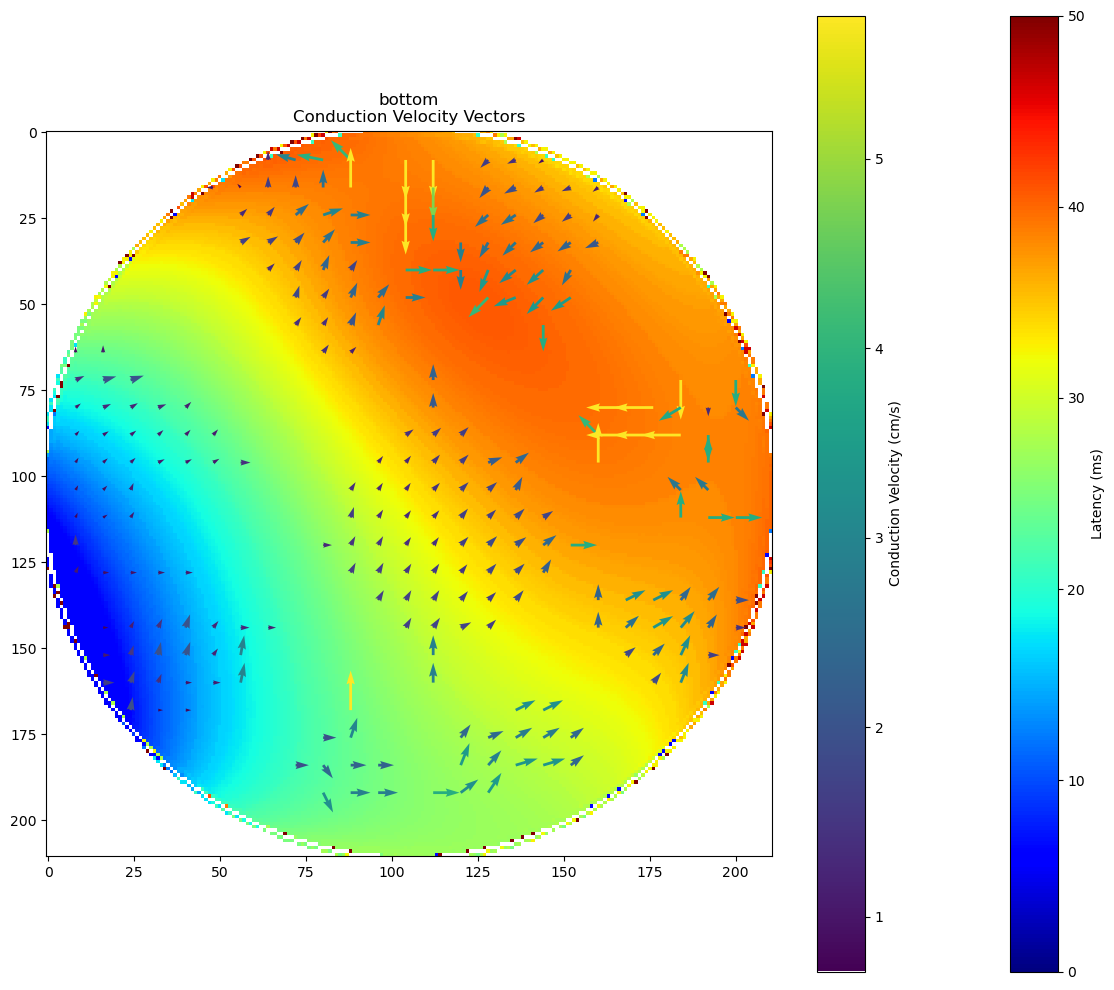

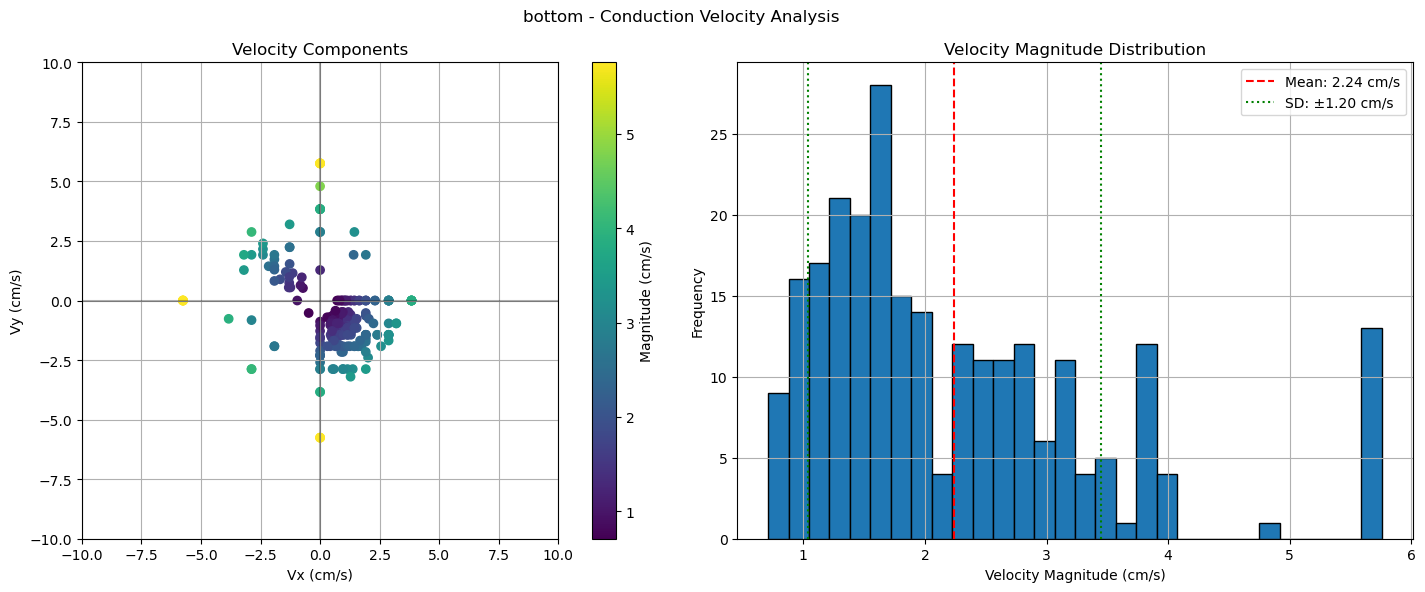


Conduction Velocity Statistics for bottom
Mean Velocity: 2.24 ± 1.20 cm/s
Median Velocity: 1.84 cm/s
Range: 0.71 - 5.76 cm/s
Number of vectors: 247
[(0.4428369230769224, 0.9594799999999996), (1.4023169230769277, 0.0), (1.7818914285714342, 0.0), (1.6448228571428578, 0.0), (2.302751999999996, 0.0), (2.302751999999996, 0.0), (0.0, 5.756880000000031), (1.6448228571428578, 0.0), (1.6448228571428578, 0.0), (1.0965485714285703, 0.6396533333333331), (1.6448228571428556, 0.0), (1.973787428571435, 0.0), (2.3027520000000123, 0.0), (1.918959999999999, 0.0), (0.9594799999999996, 1.9189600000000104), (3.837920000000021, 0.0), (4.797400000000026, 0.0), (2.8784400000000154, 2.8784400000000154), (-5.756880000000031, 0.0), (-2.8784400000000154, 2.8784400000000154), (0.8224114285714289, -0.575688), (1.6448228571428598, 0.0), (1.0965485714285732, -1.9189600000000102), (1.187927619047619, -1.9189600000000102), (0.9594799999999996, -2.8784400000000154), (1.2793066666666684, 0.0), (0.6396533333333342, 1.918

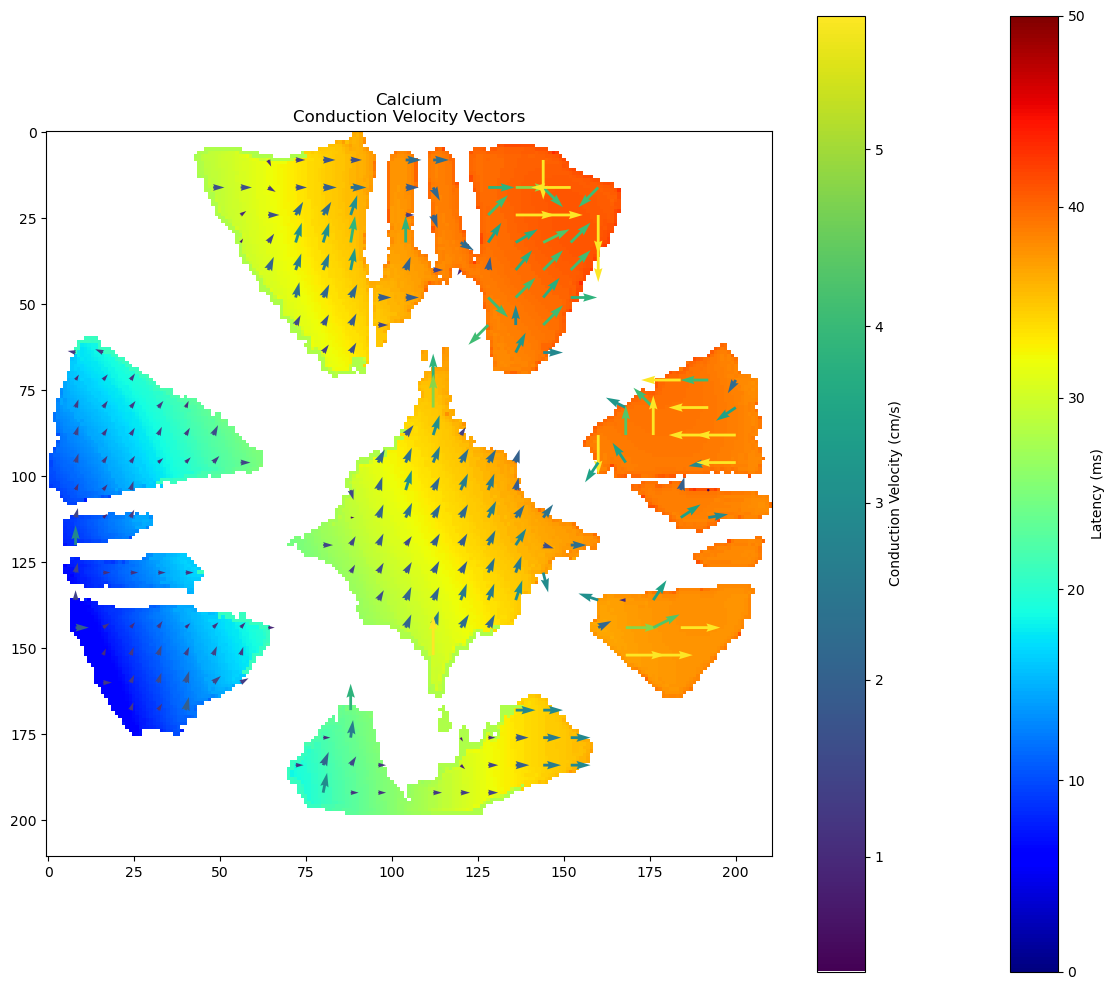

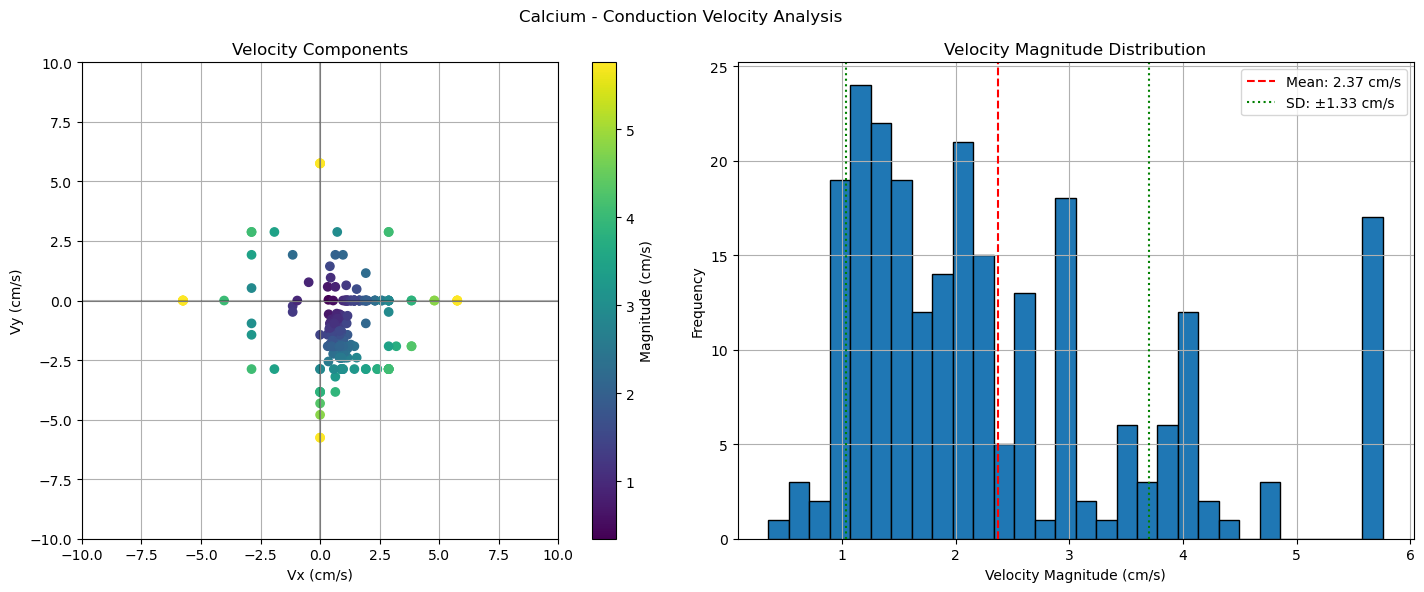


Conduction Velocity Statistics for Calcium
Mean Velocity: 2.37 ± 1.33 cm/s
Median Velocity: 2.01 cm/s
Range: 0.35 - 5.76 cm/s
Number of vectors: 242
[(-0.5233527272727284, -0.22141846153846184), (-0.7753373737373751, -0.19189599999999998), (-1.3859155555555527, -0.2558613333333329), (-1.439219999999995, -0.41120571428571445), (-2.8784399999999644, -0.575688), (-2.8784399999999644, -0.7196100000000023), (0.0, -1.9189599999999936), (-2.8784400000000154, -0.8224114285714309), (-2.8784400000000154, -1.4392200000000077), (-0.8224114285714289, -0.30299368421052625), (-0.9868937142857135, -0.29061173076923086), (-1.2952979999999965, -0.3495248571428572), (-1.6790900000000026, -0.43176599999999987), (-1.2793066666666737, -0.7005726984126982), (0.0, -1.5351679999999996), (0.0, -1.8709860000000045), (0.0, -2.398699999999998), (0.0, -3.7008514285714464), (1.9189600000000104, -1.4392200000000077), (1.9189600000000104, -1.9189600000000104), (-0.959480000000001, -0.4972204048582995), (-1.6790900000

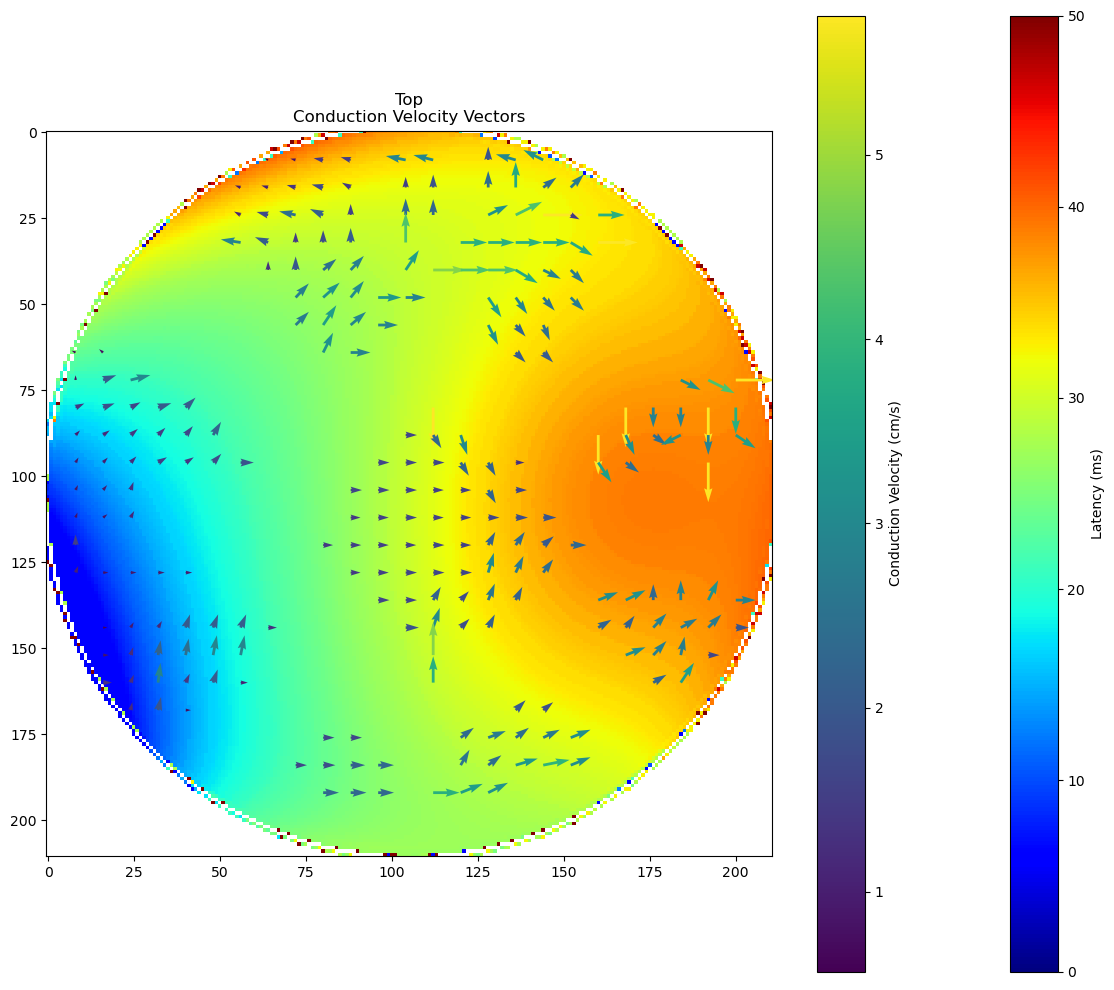

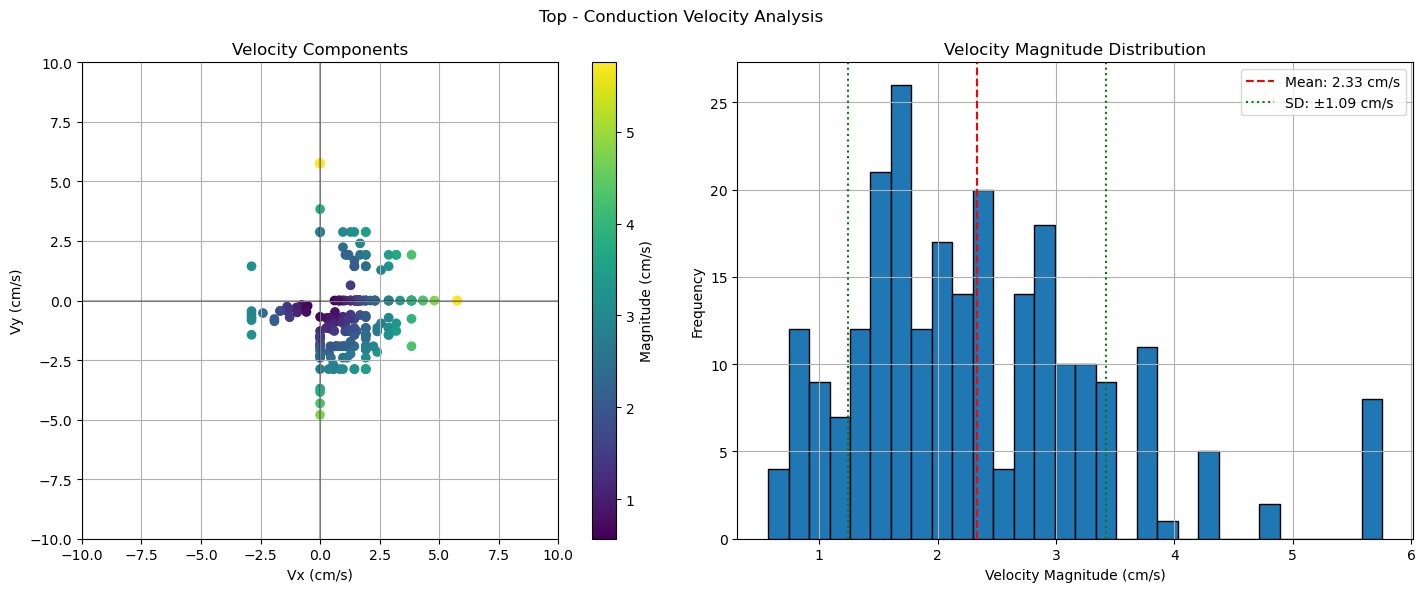


Conduction Velocity Statistics for Top
Mean Velocity: 2.33 ± 1.09 cm/s
Median Velocity: 2.16 cm/s
Range: 0.57 - 5.76 cm/s
Number of vectors: 246
[(-0.9594799999999996, -0.3289645714285709), (-1.337456969696971, -0.28429037037037), (-1.9771103030302963, -0.3837919999999993), (-1.9189599999999876, -0.7196100000000007), (-3.837919999999975, -1.4392200000000077), (-3.837919999999975, -1.9189600000000104), (-5.756879999999929, 0.0), (-4.029815999999962, 0.0), (-1.151375999999998, 1.6448228571428578), (-0.6223654054054057, 0.0), (-1.1669351351351234, -0.2558613333333329), (-2.1588299999999987, -0.4261586493506496), (-2.8784400000000154, -0.501061777777778), (-1.9189600000000102, -0.8635319999999999), (0.0, -1.8709859999999987), (0.0, -4.317659999999972), (0.0, -3.837920000000021), (-7.67583999999995, 0.0), (-5.1172266666666335, 1.9189600000000102), (-2.5586133333333168, 2.6317165714285693), (-1.9189600000000104, 2.8784399999999644), (-1.9189600000000104, 1.4392200000000077), (0.0, -0.959479

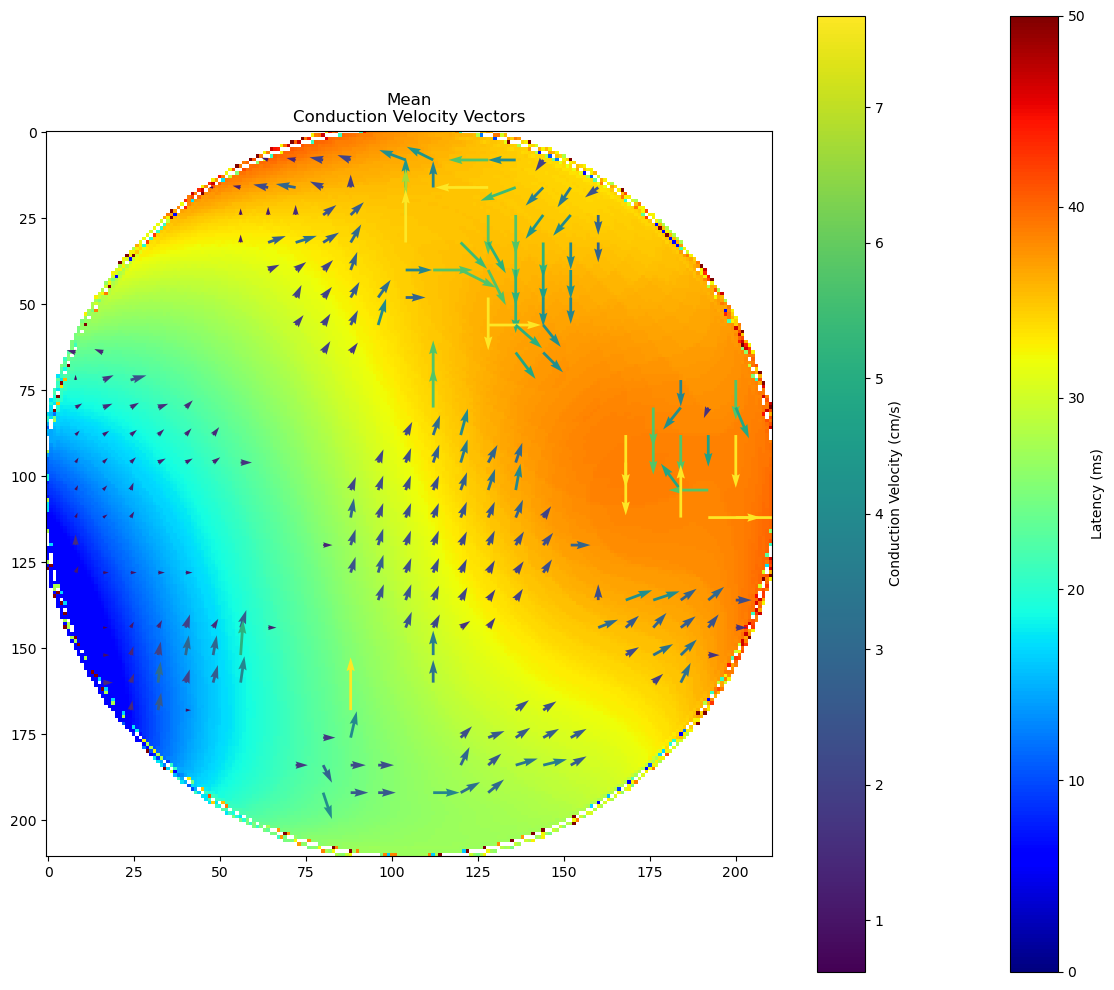

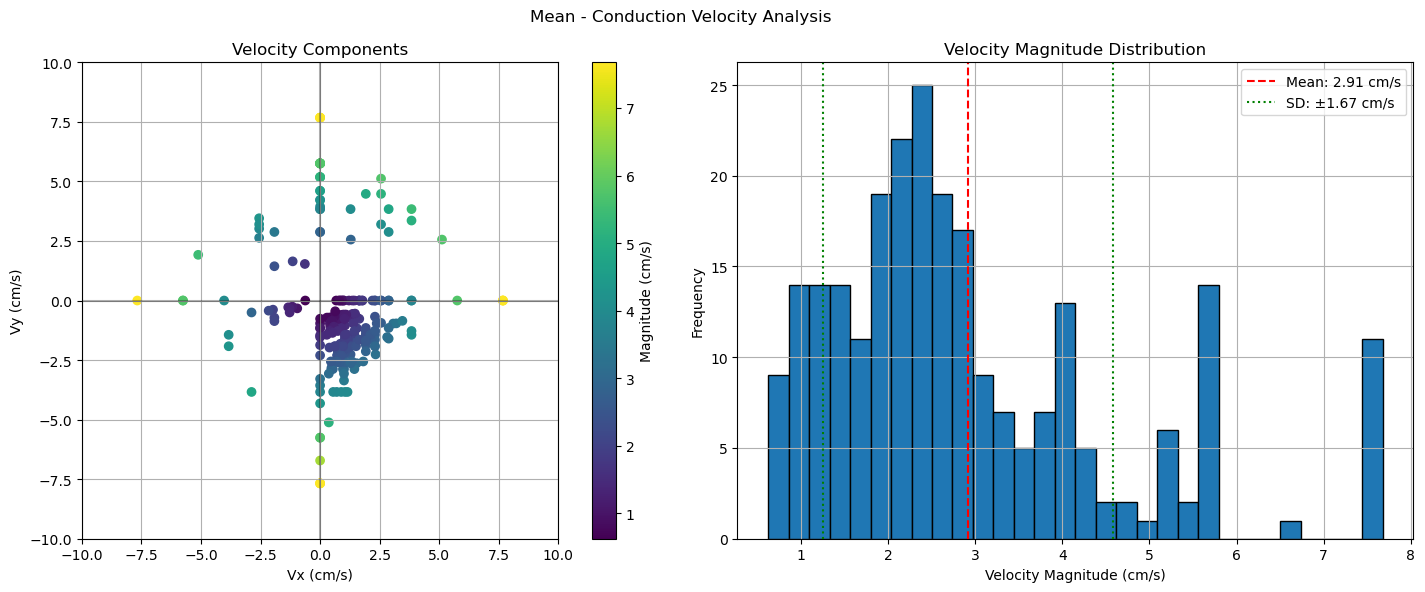


Conduction Velocity Statistics for Mean
Mean Velocity: 2.91 ± 1.67 cm/s
Median Velocity: 2.45 cm/s
Range: 0.62 - 7.68 cm/s
Number of vectors: 249
Excel file 'velocity_amplitude_results.xlsx' created successfully.


In [13]:
import numpy as np
import pandas as pd

def main():
    data1 = np.load('data/extracted_data1.npy') / 2
    data2 = np.load('data/extracted_data2.npy') / 2
    data3 = np.load('data/extracted_data3.npy') / 2
    data_mean13 = np.nanmean(np.stack([data1, data3]), axis=0)
    
    _, _, sampling_points = sample_and_pair_data(data1, data2, sampling_rate=SAMPLING_RATE)
    
    datasets = [
        (data1, "bottom"),
        (data2, "Calcium"),
        (data3, "Top"),
        (data_mean13, "Mean")
    ]
    
    all_velocities = []
    titles = []
    
    for data, title in datasets:
        positions, velocities = calculate_velocities(data, sampling_points)
        print(velocities)
        print(velocities)
        if len(positions) > 0:
            plot_velocity_vectors(data, positions, velocities, title)
            plot_velocity_scatter(velocities, title)
            all_velocities.append(velocities)
            titles.append(title)
        else:
            print(f"No valid velocities calculated for {title}")

    # Calculate amplitude and save results
    if all_velocities:
        amplitude_data = {}

        for velocities, title in zip(all_velocities, titles):
            velocities = np.array(velocities)
            amp = np.sqrt(velocities[:, 0]**2 + velocities[:, 1]**2)   # Compute amplitude
            
            # Create heading with mean, median, and std
            heading = f'{title} (Mean: {np.mean(amp):.2f}, Median: {np.median(amp):.2f}, Std: {np.std(amp):.2f})'
            amplitude_data[heading] = amp

        df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in amplitude_data.items()]))
        df.to_excel('velocity_amplitude_results.xlsx', index=False)
        print("Excel file 'velocity_amplitude_results.xlsx' created successfully.")

main()
